In [2]:
import numpy as np
import pandas as pd
import math

from croissance import process_curve
from croissance.estimation import fit_exponential
from croissance.estimation.util import normalize_time_unit
from croissance.figures import PDFWriter

import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit

import seaborn as sns

# Function to analyze growth curve

In [72]:
# "infile" is the relative/full path of the growth curve experimental data of 96-well plates
# check 181109_glycerol_clinical.csv for input data format

# min_od: regions with od smaller than min_od will be removed

# blank: row or column used as blank control wells. Allowed values: 'A'-'H' for rows and '1'-'12' for columns

# verbose: whether to print information in process

# myxlim, myylim: xlim and ylim of plot

def growth_curve_analysis(infile, min_od=None, blank=None, verbose=True, myxlim=None, myylim=None):
    # read data
    if infile.split('.')[-1] == 'xlsx':
        df = pd.read_excel(infile, index_col=1).squeeze()
    elif infile.split('.')[-1] == 'csv':
        df = pd.read_csv(infile, index_col=1).squeeze()
    else:
        print('file format not recognized. support xlsx and csv only.')
        return
    
    # remove columns for temperature and cycle
    df=df.drop(columns=[df.columns[0],df.columns[1]])
    
    # convert time unit to hour
    df.index = df.index/3600
    df.index.names = ['Time (h)']
    
    #print(df.head())

    # subtract baseline data (controls)
    if blank is not None:
        if blank.isalpha():
            # the blank is a row
            for index, col in enumerate(df.columns):
                # the variable "blank" is a letter, we need digits
                digits = ''.join(i for i in col if i.isdigit())
                #print(col, blank+digits)
                blank_index = df.columns.values.tolist().index(blank + digits)
                df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
    
        if blank.isdigit():
            # the blank is a column
            for index, col in  enumerate(df.columns):
                # the variable "blank" is digital, we need a letter
                letter = ''.join(i for i in col if i.isalpha())
                #print(col, letter+blank)
                blank_index = df.columns.values.tolist().index(letter + blank)
                df.iloc[:,index] = df.iloc[:,index] - df.iloc[:,blank_index]
            
    # to plot
    fig, axes = plt.subplots(nrows=8, ncols=12, figsize=(16, 10))
  
    saved_data = []
    for index, col in enumerate(df.columns): 
        row_index = int(index % 8)
        col_index = int(np.floor(index/8))   
        
        try:
            # cutoff OD
            if min_od is None:
                curve = df[col]
            else:
                curve = df.loc[df[col] >= min_od, col]
                
            if curve.empty: # curve is empty
                mydict = {}
                mydict.update({'StartT1' : float('nan'),
                               'EndT1'   : float('nan'),
                               'GR1'     : float('nan'),
                               'LagT1'   : float('nan'),
                               'StartT2' : float('nan'),
                               'EndT2'   : float('nan'),
                               'GR2'     : float('nan'),
                               'LagT2'   : float('nan'),
                               'StartT3' : float('nan'),
                               'EndT3'   : float('nan'),
                               'GR3'     : float('nan'),
                               'LagT3'   : float('nan'),
                               'minGR'   : float('nan'),
                               'maxGR'   : float('nan'),
                               'InitOD'  : float('nan'),
                               'MaxOD'   : float('nan'),
                               'FinalOD' : float('nan')})
            
                print(col, ': no growth phase is found.')
            
                saved_data.append(mydict)
            
                axes[row_index, col_index].set_xticklabels([])
                axes[row_index, col_index].set_yticklabels([]) 
                axes[row_index, col_index].minorticks_off()
            
                continue
            else:
                # extract growth parameters using croissance
                results = process_curve(curve,constrain_n0=True, n0=0.)
            
        except:
            # no cutoff
            curve = df[col]
            if curve.empty: # curve is empty
                mydict = {}
                mydict.update({'StartT1' : float('nan'),
                               'EndT1'   : float('nan'),
                               'GR1'     : float('nan'),
                               'LagT1'   : float('nan'),
                               'StartT2' : float('nan'),
                               'EndT2'   : float('nan'),
                               'GR2'     : float('nan'),
                               'LagT2'   : float('nan'),
                               'StartT3' : float('nan'),
                               'EndT3'   : float('nan'),
                               'GR3'     : float('nan'),
                               'LagT3'   : float('nan'),
                               'minGR'   : float('nan'),
                               'maxGR'   : float('nan'),
                               'InitOD'  : float('nan'),
                               'MaxOD'   : float('nan'),
                               'FinalOD' : float('nan')})
            
                print(col, ': no growth phase is found.')
            
                saved_data.append(mydict)
            
                axes[row_index, col_index].set_xticklabels([])
                axes[row_index, col_index].set_yticklabels([]) 
                axes[row_index, col_index].minorticks_off()
            
                continue
            else:
                # extract growth parameters using croissance
                results = process_curve(curve,constrain_n0=True, n0=0.)
            
        # find the index of the first growth phase
        phase_start = []
        for phase in results.growth_phases:
            phase_start.append(phase.start)
        if phase_start:
            first_growth_phase_index = np.argmin(phase_start)
            phase_order_in_time = np.argsort(phase_start)
    
        # get growth rate and lag time for each growth phase
        # for the first phase, we fit an exponential model with a free-varying constant offset
        # for all other phases (which may or may not grow exponential), we approximat it using exponential model
        growth_rate = []
        growth_lag  = []
        rank = []
        startT = []
        endT = []
        colors = ["#e74c3c", "#3498db", "#9b59b6", "#95a5a6", "#2ecc71"]
        for phase_index, phase in enumerate(results.growth_phases): # growth phases have been ranked
            
            phase_series = results.series[phase.start:phase.end]
            rank.append(phase.rank)
            startT.append(phase.start)
            endT.append(phase.end)
                
            def exp_growth_w_offset(x, y0, y1, mu):
                return y0 + y1 * np.exp(mu * x)
            
            def exp_growth_wo_offset(x, y1, mu):
                return y1 * np.exp(mu * x)
            
            w_offset = True
            try:
                # fit with w/ offset model
                init_vals = [phase_series.values[0], 
                            1/ np.exp(phase.intercept * phase.slope),
                            phase.slope]  # for [y0, y1, mu]
                best_vals, covar = curve_fit(exp_growth_w_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                             bounds = ([0,0,0], [math.inf,math.inf,math.inf]), maxfev=10000)
                    
                trial_growth_lag = np.log(best_vals[0]/best_vals[1])/best_vals[2]
                if (trial_growth_lag <0):
                    #print('%s: lag time is negative using w/ offset model. Using w/o offset model instead.' % (col))
                    raise ValueError
                else:
                    growth_rate.append(best_vals[2])
                    growth_lag.append(trial_growth_lag)
            except:
                # fit with w/o offset model
                w_offset = False
                init_vals = [1/ np.exp(phase.intercept * phase.slope),
                             phase.slope]  # for [y1, mu]
                best_vals, covar = curve_fit(exp_growth_wo_offset, phase_series.index, phase_series.values, p0=init_vals, 
                                             bounds = ([0,0], [math.inf,math.inf]), maxfev=10000)
                    
                trial_growth_lag = -np.log(best_vals[0])/best_vals[1]
                if (trial_growth_lag <0):
                    print('%s: lag time is negative. Terminate.' % (col))
                    raise ValueError
                else:
                    growth_rate.append(best_vals[1])
                    growth_lag.append(trial_growth_lag)
                        
            if (growth_rate[-1]<0):
                print('%s: growth rate is negative. Terminate.' % (col))
                raise ValueError
            
            #=======
            # plot
            #=======
            color = colors[phase_index % len(colors)]
            # plot local growth phases identified by croissance
            axes[row_index, col_index].plot(phase_series.index,
                                            phase_series.values,
                                            marker=None,
                                            linewidth=5,
                                            color=color,
                                            solid_capstyle='butt',
                                            alpha=0.5)
            # plot model fitting
            if w_offset:
                axes[row_index, col_index].plot(results.series.index,
                                                exp_growth_w_offset(results.series.index, best_vals[0], best_vals[1], best_vals[2]), 
                                                color=color,
                                                linewidth=1,
                                                linestyle='solid')
            else:
                axes[row_index, col_index].plot(results.series.index,
                                                exp_growth_wo_offset(results.series.index, best_vals[0], best_vals[1]), 
                                                color=color,
                                                linewidth=1,
                                                linestyle='solid')
                
        if verbose:
            if len(results.growth_phases)==0:
                print(col, ': no growth phase is found.')
            else:
                print('%s : %d growth phases found, rank=(' % (col, len(results.growth_phases)), end='')
                for index_phase in range(len(results.growth_phases)):
                    if index_phase == len(results.growth_phases)-1:
                        print('%3.2f), growth rate=(' % rank[phase_order_in_time[index_phase]], end='')
                    else:
                        print('%3.2f,' % rank[phase_order_in_time[index_phase]], end='')
                        
                for index_phase in range(len(results.growth_phases)):
                    if index_phase == len(results.growth_phases)-1:
                        print('%1.2f), growth lag=(' % growth_rate[phase_order_in_time[index_phase]], end='')
                    else:
                        print('%1.2f,' % growth_rate[phase_order_in_time[index_phase]], end='')
                
                for index_phase in range(len(results.growth_phases)):
                    if index_phase == len(results.growth_phases)-1:
                        print('%2.2f)' % growth_lag[phase_order_in_time[index_phase]])
                    else:
                        print('%2.2f,' % growth_lag[phase_order_in_time[index_phase]], end='')

        mydict = {}      
        if len(results.growth_phases)==0:
            mydict.update({'StartT1' : float('nan'),
                           'EndT1'   : float('nan'),
                           'GR1'     : float('nan'),
                           'LagT1'   : float('nan'),
                           'StartT2' : float('nan'),
                           'EndT2'   : float('nan'),
                           'GR2'     : float('nan'),
                           'LagT2'   : float('nan'),
                           'StartT3' : float('nan'),
                           'EndT3'   : float('nan'),
                           'GR3'     : float('nan'),
                           'LagT3'   : float('nan'),
                           'minGR'   : float('nan'),
                           'maxGR'   : float('nan'),
                           'InitOD'  : curve.values[0],
                           'MaxOD'   : np.max(curve.values),
                           'FinalOD' : curve.values[-1]})
        else:
            mydict.update({'StartT1' : startT[phase_order_in_time[0]] if len(growth_rate)>=1 else float('nan'),
                           'EndT1'   : endT[phase_order_in_time[0]] if len(growth_rate)>=1 else float('nan'),
                           'GR1'     : growth_rate[phase_order_in_time[0]] if len(growth_rate)>=1 else float('nan'),
                           'LagT1'   : growth_lag[phase_order_in_time[0]] if len(growth_rate)>=1 else float('nan'),
                           'StartT2' : startT[phase_order_in_time[1]] if len(growth_rate)>=2 else float('nan'),
                           'EndT2'   : endT[phase_order_in_time[1]] if len(growth_rate)>=2 else float('nan'),
                           'GR2'     : growth_rate[phase_order_in_time[1]] if len(growth_rate)>=2 else float('nan'),
                           'LagT2'   : growth_lag[phase_order_in_time[1]] if len(growth_rate)>=2 else float('nan'),
                           'StartT3' : startT[phase_order_in_time[2]] if len(growth_rate)>=3 else float('nan'),
                           'EndT3'   : endT[phase_order_in_time[2]] if len(growth_rate)>=3 else float('nan'),
                           'GR3'     : growth_rate[phase_order_in_time[2]] if len(growth_rate)>=3 else float('nan'),
                           'LagT3'   : growth_lag[phase_order_in_time[2]] if len(growth_rate)>=3 else float('nan'),
                           'minGR'   : np.min(growth_rate) if len(growth_rate)>=1 else float('nan'),
                           'maxGR'   : np.max(growth_rate) if len(growth_rate)>=1 else float('nan'),
                           'InitOD'  : curve.values[0],
                           'MaxOD'   : np.max(curve.values),
                           'FinalOD' : curve.values[-1]})

        saved_data.append(mydict)
        
        #======
        # plot
        #======                  
        # plot original data
        axes[row_index, col_index].plot(results.series.index,
                                        results.series.values,
                                        color='black',
                                        marker='.',
                                        markersize=1,
                                        linestyle='None')
        # plot outliers
        axes[row_index, col_index].plot(results.outliers.index,
                                        results.outliers.values,
                                        color='red',
                                        marker='.',
                                        markersize=1,
                                        linestyle='None')
        
        # set xlim
        if myxlim is not None:
            axes[row_index, col_index].set_xlim(myxlim)
        else:
            axes[row_index, col_index].set_xlim([0,np.max(df.index.values)])
        
        # set ylim
        if myylim is not None:
            axes[row_index, col_index].set_ylim(myylim)
        else:
            if curve.max()>0:
                if curve.min()>0:
                    axes[row_index, col_index].set_ylim([curve.min()/2, curve.max()*2])
                else:
                    axes[row_index, col_index].set_ylim([0.005, curve.max()*2])
        
        axes[row_index, col_index].set_yscale('log')
        axes[row_index, col_index].set_xticklabels([])
        axes[row_index, col_index].set_yticklabels([]) 
        axes[row_index, col_index].minorticks_off()
        
    # output
    Op = pd.DataFrame(saved_data)
    Op = Op[['StartT1','EndT1','GR1','LagT1',
             'StartT2','EndT2','GR2','LagT2',
             'StartT3','EndT3','GR3','LagT3',
             'minGR','maxGR','InitOD','MaxOD','FinalOD']]
    Op.index = df.columns
    
    plt.show()
    plt.tight_layout()
    
    return Op

# Run example 1: Pseudomonas aeruginosa in glycerol minimal

A1 : no growth phase is found.
B1 : no growth phase is found.
C1 : no growth phase is found.
D1 : no growth phase is found.
E1 : no growth phase is found.
F1 : no growth phase is found.
G1 : no growth phase is found.
H1 : no growth phase is found.
A2 : 2 growth phases found, rank=(100.00,43.25), growth rate=(0.30,0.02), growth lag=(17.06,53.53)
B2 : 2 growth phases found, rank=(73.21,62.59), growth rate=(0.31,0.03), growth lag=(17.17,42.42)
C2 : 2 growth phases found, rank=(53.68,61.52), growth rate=(0.30,0.03), growth lag=(17.21,42.15)
D2 : 2 growth phases found, rank=(47.72,64.32), growth rate=(0.32,0.07), growth lag=(16.89,39.17)
E2 : 2 growth phases found, rank=(55.54,60.93), growth rate=(0.28,0.03), growth lag=(17.55,39.42)
F2 : 2 growth phases found, rank=(56.29,59.79), growth rate=(0.30,0.09), growth lag=(17.16,40.89)
G2 : 2 growth phases found, rank=(55.21,60.92), growth rate=(0.28,0.03), growth lag=(16.66,37.56)
H2 : 2 growth phases found, rank=(100.00,57.93), growth rate=(0.2

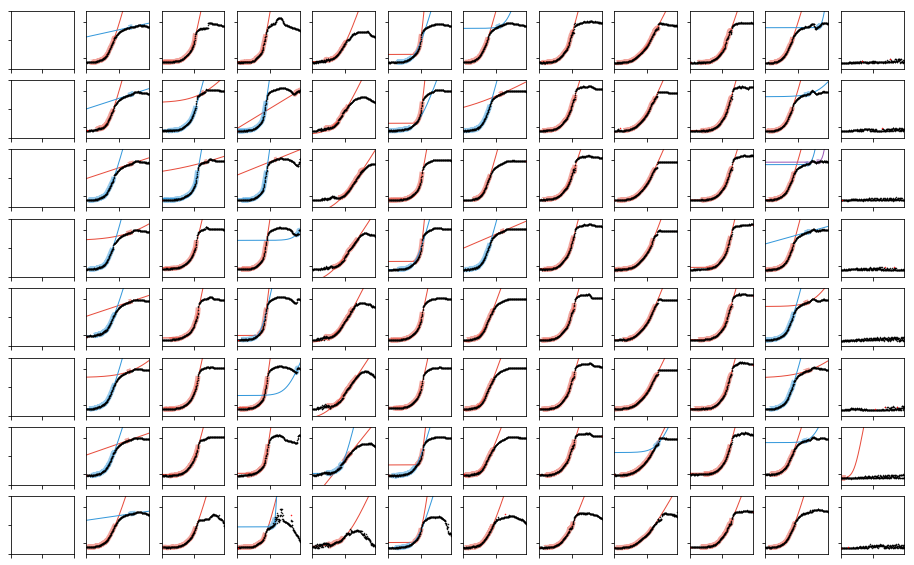

<Figure size 432x288 with 0 Axes>

In [65]:
output1 = growth_curve_analysis(infile='181109_glycerol_clinical.csv', min_od=0.01, blank='1', verbose=True,
                                myxlim=[0,48], myylim=[0.05,2])

In [66]:
pd.set_option('precision', 2) 
output1.head(10)
#export_csv = output1.to_csv ('output1.csv', index=True, header=True)

,StartT1,EndT1,GR1,LagT1,StartT2,EndT2,GR2,LagT2,StartT3,EndT3,GR3,LagT3,minGR,maxGR,InitOD,MaxOD,FinalOD
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,3.22,21.85,0.30,17.06,32.68,34.89,0.02,53.53,NaN,NaN,NaN,NaN,0.02,0.30,0.07,0.80,0.70
B2,7.96,20.83,0.31,17.17,32.52,35.73,0.03,42.42,NaN,NaN,NaN,NaN,0.03,0.31,0.08,0.97,0.83


## Visualize growth rate

0.13  GR1 (1/h)  0.62
0.01  GR2 (1/h)  1.71
0.82  GR3 (1/h)  0.82


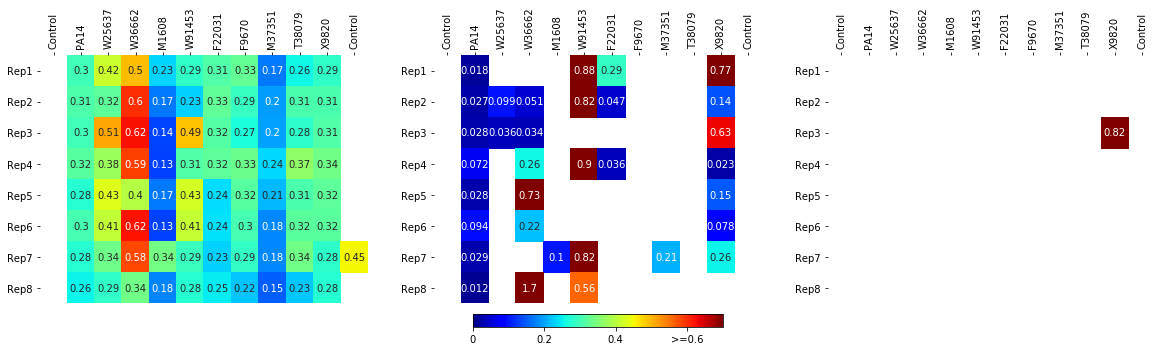

In [67]:
print('%2.2f  GR1 (1/h)  %2.2f' %(np.nanmin(output1['GR1'].values), np.nanmax(output1['GR1'].values)))
print('%2.2f  GR2 (1/h)  %2.2f' %(np.nanmin(output1['GR2'].values), np.nanmax(output1['GR2'].values)))
print('%2.2f  GR3 (1/h)  %2.2f' %(np.nanmin(output1['GR3'].values), np.nanmax(output1['GR3'].values)))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

# 1st phase growth rate
to_plot1 = pd.DataFrame(output1['GR1'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=0.7, ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')

# 2nd phase growth rate
to_plot2 = pd.DataFrame(output1['GR2'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=0.7, ax=ax2, cbar=False)
g2.set_ylabel('')
g2.set_xlabel('')

# 3rd phase growth rate
to_plot3 = pd.DataFrame(output1['GR3'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='jet', vmin=0, vmax=0.7, ax=ax3, cbar=False)
g3.set_ylabel('')
g3.set_xlabel('')

for ax in [g1,g2,g3]:
    ax.set_yticklabels(['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6','Rep7','Rep8'], rotation=0)
    ax.set_xticklabels(['Control','PA14','W25637','W36662','M1608','W91453','F22031','F9670','M37351','T38079','X9820','Control'], rotation=90)
    ax.xaxis.tick_top()
    
mappable = g1.get_children()[0]
cbar=plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.2,0.4,0.6])
cbar.set_ticklabels(['0','0.2','0.4','>=0.6'])

plt.show()

## Visualize lag time

10.51 <= LagT1 (h) <= 26.21
1.87 <= LagT2 (h) <= 68.41
44.83 <= LagT3 (h) <= 44.83


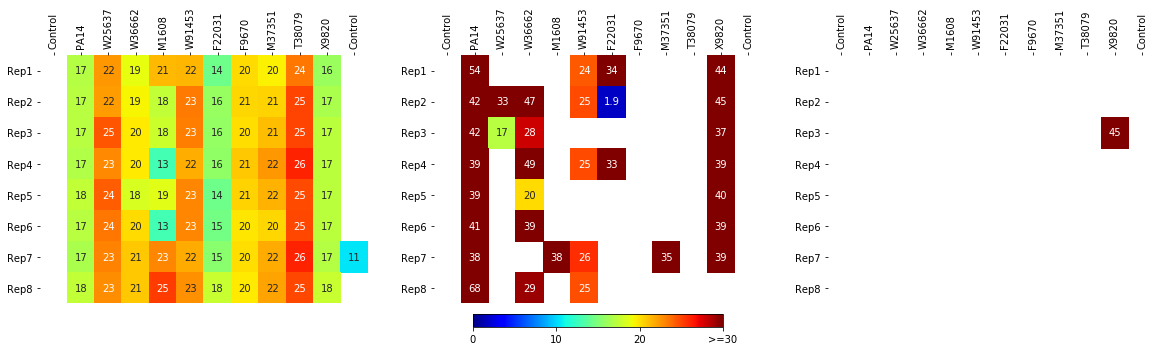

In [69]:
print('%2.2f <= LagT1 (h) <= %2.2f' %(np.nanmin(output1['LagT1'].values), np.nanmax(output1['LagT1'].values)))
print('%2.2f <= LagT2 (h) <= %2.2f' %(np.nanmin(output1['LagT2'].values), np.nanmax(output1['LagT2'].values)))
print('%2.2f <= LagT3 (h) <= %2.2f' %(np.nanmin(output1['LagT3'].values), np.nanmax(output1['LagT3'].values)))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

# 1st phase growth rate
to_plot1 = pd.DataFrame(output1['LagT1'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')

# 2nd phase growth rate
to_plot2 = pd.DataFrame(output1['LagT2'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax2, cbar=False)
g2.set_ylabel('')
g2.set_xlabel('')

# 3rd phase growth rate
to_plot3 = pd.DataFrame(output1['LagT3'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax3, cbar=False)
g3.set_ylabel('')
g3.set_xlabel('')

for ax in [g1,g2,g3]:
    ax.set_yticklabels(['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6','Rep7','Rep8'], rotation=0)
    ax.set_xticklabels(['Control','PA14','W25637','W36662','M1608','W91453','F22031','F9670','M37351','T38079','X9820','Control'], rotation=90)
    ax.xaxis.tick_top()
    
mappable = g1.get_children()[0]
cbar=plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_ticks([0,10,20,30])
cbar.set_ticklabels(['0','10','20','>=30'])

plt.show()

# Run example 2: PA14 and NalD mutant in glycerol + casamino acids

A1 : 2 growth phases found, rank=(83.63,36.79), growth rate=(1.03,0.01), growth lag=(6.71,108.03)
B1 : 1 growth phases found, rank=(100.00), growth rate=(1.12), growth lag=(6.60)
C1 : 2 growth phases found, rank=(93.40,33.66), growth rate=(1.04,1.07), growth lag=(1.92,16.73)
D1 : 1 growth phases found, rank=(100.00), growth rate=(1.12), growth lag=(6.51)
E1 : 1 growth phases found, rank=(100.00), growth rate=(1.43), growth lag=(0.81)
F1 : 2 growth phases found, rank=(77.88,55.94), growth rate=(1.90,0.39), growth lag=(6.26,28.34)
G1 : no growth phase is found.
H1 : no growth phase is found.
A2 : 1 growth phases found, rank=(100.00), growth rate=(1.11), growth lag=(6.60)
B2 : 2 growth phases found, rank=(85.30,48.25), growth rate=(0.99,0.03), growth lag=(6.97,53.22)
C2 : 2 growth phases found, rank=(86.45,35.86), growth rate=(1.01,0.03), growth lag=(6.95,55.89)
D2 : 2 growth phases found, rank=(85.60,34.09), growth rate=(0.96,0.82), growth lag=(1.17,18.88)
E2 : 1 growth phases found, ran

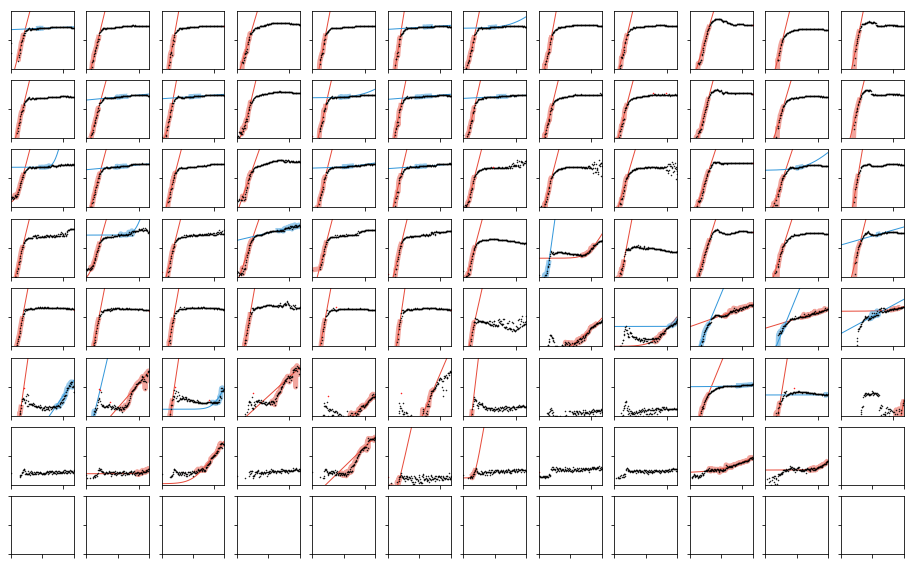

<Figure size 432x288 with 0 Axes>

In [76]:
# Cutoff at zero causes divided by zero error. Switch to no cutoff
output2 = growth_curve_analysis(infile='181219_aztMIC.xlsx', min_od=0.01, blank='H', verbose=True,
                                myxlim=[0,24], myylim=[0.005,2])

In [77]:
pd.set_option('precision', 2) 
output2.head(10)
#export_csv = output2.to_csv ('output2.csv', index=True, header=True)

,StartT1,EndT1,GR1,LagT1,StartT2,EndT2,GR2,LagT2,StartT3,EndT3,GR3,LagT3,minGR,maxGR,InitOD,MaxOD,FinalOD
A1,2.88,5.08,1.03,6.71,9.65,12.53,0.01,108.03,NaN,NaN,NaN,NaN,0.01,1.03,7.09e-02,0.37,0.35
B1,1.35,4.91,1.12,6.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,1.12,-2.30e-03,0.38,0.35
C1,1.35,4.91,1.04,1.92,10.67,14.73,1.07,16.73,NaN,NaN,NaN,NaN,1.04,1.07,1.21e-02,0.43,0.42
D1,1.52,4.74,1.12,6.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.12,1.12,3.10e-03,0.69,0.68
E1,1.52,4.57,1.43,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,1.43,4.30e-03,0.28,0.21
F1,0.85,4.06,1.90,6.26,17.11,23.71,0.39,28.34,NaN,NaN,NaN,NaN,0.39,1.90,-4.00e-04,0.16,0.06
G1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.76e-02,0.03,0.02
H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,1.35,4.91,1.11,6.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,1.11,0.00e+00,0.43,0.41
B2,1.52,4.74,0.99,6.97,11.35,15.92,0.03,53.22,NaN,NaN,NaN,NaN,0.03,0.99,5.00e-03,0.44,0.40


## Visualize growth rate

0.15  GR1 (1/h)  2.26
0.01  GR2 (1/h)  1.82
nan  GR3 (1/h)  nan


/Users/liaoc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until


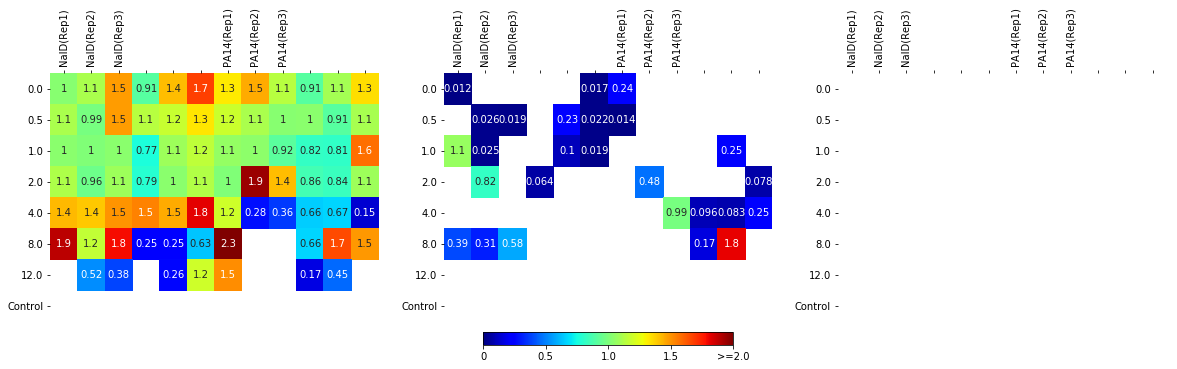

In [78]:
print('%2.2f  GR1 (1/h)  %2.2f' %(np.nanmin(output2['GR1'].values), np.nanmax(output2['GR1'].values)))
print('%2.2f  GR2 (1/h)  %2.2f' %(np.nanmin(output2['GR2'].values), np.nanmax(output2['GR2'].values)))
print('%2.2f  GR3 (1/h)  %2.2f' %(np.nanmin(output2['GR3'].values), np.nanmax(output2['GR3'].values)))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

# 1st phase growth rate
to_plot1 = pd.DataFrame(output2['GR1'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=2, ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')

# 2nd phase growth rate
to_plot2 = pd.DataFrame(output2['GR2'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=2, ax=ax2, cbar=False)
g2.set_ylabel('')
g2.set_xlabel('')

# 3rd phase growth rate
to_plot3 = pd.DataFrame(output2['GR3'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='jet', vmin=0, vmax=2, ax=ax3, cbar=False)
g3.set_ylabel('')
g3.set_xlabel('')

for ax in [g1,g2,g3]:
    ax.set_yticklabels(['0.0','0.5','1.0','2.0','4.0','8.0','12.0','Control'], rotation=0)
    ax.set_xticklabels(['NalD(Rep1)','NalD(Rep2)','NalD(Rep3)','','','','PA14(Rep1)','PA14(Rep2)','PA14(Rep3)','','',''], rotation=90)
    ax.xaxis.tick_top()
    
mappable = g1.get_children()[0]
cbar=plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_ticks([0,0.5,1.0,1.5,2.0])
cbar.set_ticklabels(['0','0.5','1.0','1.5','>=2.0'])

plt.show()

## Visualize lag time

0.81 <= LagT1 (h) <= 36.82
16.73 <= LagT2 (h) <= 108.03
nan <= LagT3 (h) <= nan


/Users/liaoc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until


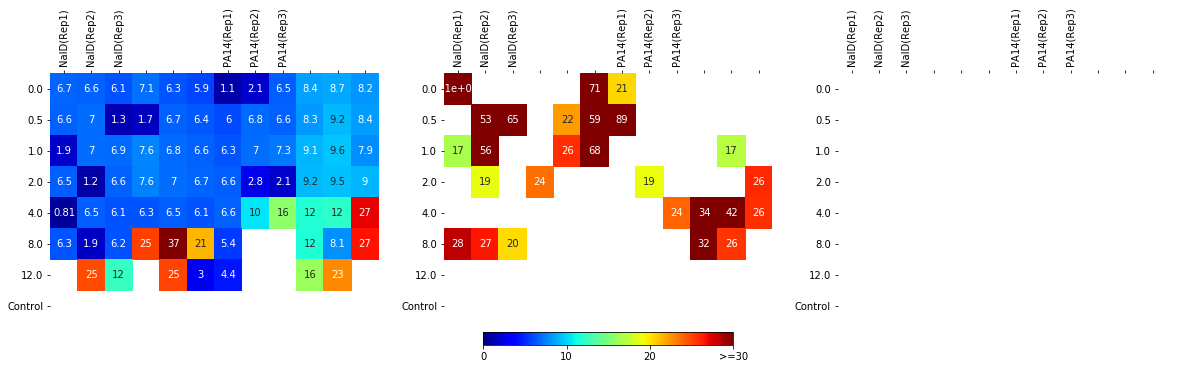

In [79]:
print('%2.2f <= LagT1 (h) <= %2.2f' %(np.nanmin(output2['LagT1'].values), np.nanmax(output2['LagT1'].values)))
print('%2.2f <= LagT2 (h) <= %2.2f' %(np.nanmin(output2['LagT2'].values), np.nanmax(output2['LagT2'].values)))
print('%2.2f <= LagT3 (h) <= %2.2f' %(np.nanmin(output2['LagT3'].values), np.nanmax(output2['LagT3'].values)))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1,1]},figsize=(20,5))

# 1st phase growth rate
to_plot1 = pd.DataFrame(output2['LagT1'].values.reshape(8,12,order='F'))
g1 = sns.heatmap(to_plot1, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')

# 2nd phase growth rate
to_plot2 = pd.DataFrame(output2['LagT2'].values.reshape(8,12,order='F'))
g2 = sns.heatmap(to_plot2, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax2, cbar=False)
g2.set_ylabel('')
g2.set_xlabel('')

# 3rd phase growth rate
to_plot3 = pd.DataFrame(output2['LagT3'].values.reshape(8,12,order='F'))
g3 = sns.heatmap(to_plot3, robust=True, annot=True, cmap='jet', vmin=0, vmax=30, ax=ax3, cbar=False)
g3.set_ylabel('')
g3.set_xlabel('')

for ax in [g1,g2,g3]:
    ax.set_yticklabels(['0.0','0.5','1.0','2.0','4.0','8.0','12.0','Control'], rotation=0)
    ax.set_xticklabels(['NalD(Rep1)','NalD(Rep2)','NalD(Rep3)','','','','PA14(Rep1)','PA14(Rep2)','PA14(Rep3)','','',''], rotation=90)
    ax.xaxis.tick_top()
    
mappable = g1.get_children()[0]
cbar=plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'horizontal',fraction=0.046, pad=0.04)
cbar.set_ticks([0,10,20,30])
cbar.set_ticklabels(['0','10','20','>=30'])

plt.show()